# Quantitative Evaluation of SPR Data

* *Author:* Brian Josey
* *Date Created:* 2018-04-12
* *Date Modified:* 2019-08-22 by B.J.
* *Language:* Python 2.7

This notebook sets out to quantify the mass of neurotransmitters (NT) adsorbed to sparsely tethered bilayer lipid membranses (stBLM) by comparing the saturation respons in surface plasmon resonance (SPR) to the volume of adsorbed NT measured through neutron reflectometry (NR). In SPR the resonsponse of the instrument at equilibrium, $R_{eq}$, is given by a modified Langmuir isotherm:

$ R_{eq} = \frac {c R_{\infty}}{c + K_{D}} + c \frac{\mathrm{d}R}{\mathrm{d}n} \frac{\mathrm{d}n}{\mathrm{d}c} $

where:
* $c$ is the concentration,
* $R_{\infty} = R(t \rightarrow \infty)$ is the saturation as time, $t$, approaches infinity,
* $K_{D}$ is the dissociation constant,
* $\mathrm{d}R/\mathrm{d}n$ is the instrument response to changes in refractive index of the bulk solution above the interface, and 
* $\mathrm{d}n/\mathrm{d}c$ is the refractive index incriment.

This quantification will be performed by calculating the SPR response for bilayers containing an amount of adsorbed NT as measrued by NR. This calculation is performed by estimating the refractive index of the NT-lipid complex based on the volume of adsorbed NT, performed elsewhere, and then calculating the SPR response. The results of the calculation will then be compared to SPR data to determine how 1 RIU of bound NT as measured by SPR corresponds to ng/cm$^2$.

In [1]:
# Import libraries and packages.
import matplotlib.pyplot as plt
import csv

from __future__ import division, print_function, absolute_import
from tmm.tmm_core import (coh_tmm, unpolarized_RT, ellips, position_resolved, find_in_structure_with_inf)
from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d

## Parameters

There are two instruments simulated in these calculations, one at the Institute for Bioscience and Biotechnology Research (IBBR) in Rockville, MD, and the other at Carnegie Mellon University (CMU) in Pittsburgh, PA. Both systems are composed of a substrate with an stBLM resting on top of in the Kretschmann configuration with an aqueous buffer. The layers, in order, are:

* Optical substrate either sapphire (IBBR) or glass (CMU)
* Chromium
* Gold
* Submembrane water layer (tethers)
* Inner headgroup
* Hydrocarbon core
* Outer headgroup
* Buffer

The two instruments have different wavelengths, $\lambda$ = 633 nm (IBBR) or 763.8 nm (CMU), so the refractive indices differ in the metalic layers. The refractive indices are also assumed to be real in the non-metalic layers.

In [2]:
# Preliminary variables and constants.

"""
The variables and constants for the simulations are set up in this cell. They will be called to and changed in later
cells, with the specific variables.
"""

# Universal Values
DEGREE = pi/180                                                   # Perform calculations in degrees 


# Instrument and Simulation Parameters-IBBR
lam_vac_ibbr = 633                                                    # Wavelength in nm
n_aqueous = 1.335
theta_list_ibbr = linspace(60*DEGREE, 90*DEGREE, num=1500)            # Range of angles simulated
d_list_ibbr = [inf, 0.5, 4.4, 0.6, 0.900, 3.0, 0.900, inf]            # Layer thickness in nm
n_list_ibbr = [1.77, 3.0891+3.3411j, 0.13989+3.7015j, n_aqueous, 1.45, 1.45, 1.45, n_aqueous] # Refractive indices


#Instrument and Simulation Parameters-CMU
lam_vac_cmu = 763.8                                                  # Wavelength in nm
theta_list_cmu = linspace(60*DEGREE, 90*DEGREE, num=1500)        # Range of angles simulated
d_list_cmu = [inf, 0.5, 4.4, 0.6, 0.900, 3.0, 0.900, inf]            # Layer thickness in nm
n_list_cmu = [1.52, 3.095+3.428j, 0.172+4.7361j, n_aqueous, 1.45, 1.45, 1.45, n_aqueous]  # Refractive indices




In [9]:
# Define the plot and sample functions for the IBBR instrument

def plot_IBBR():
    n_list_min_ibbr = [1.77, 3.0891+3.3411j, 0.13989+3.7015j, n_aqueous, 1.45, x_ibbr_min, 1.45, n_aqueous]
    n_list_max_ibbr = [1.77, 3.0891+3.3411j, 0.13989+3.7015j, n_aqueous, 1.45, x_ibbr_max, 1.45, n_aqueous]
#    d_list_min_ibbr = [inf, 0.5, 4.4, 1.5, 4, xmin, inf]
#    d_list_max_ibbr = [inf, 0.5, 4.4, 1.5, 4, xmax, inf]
    
    Rpmin = []
    for theta in theta_list_ibbr:
        Rpmin.append(coh_tmm('p', n_list_min_ibbr, d_list_ibbr, theta, lam_vac_ibbr)['R'])
   
    Rpmax = []
    for theta in theta_list_ibbr:
        Rpmax.append(coh_tmm('p', n_list_max_ibbr, d_list_ibbr, theta, lam_vac_ibbr)['R'])
    plt.figure()
    plt.plot(theta_list_ibbr/DEGREE, Rpmin, 'red')
    plt.plot(theta_list_ibbr/DEGREE, Rpmax, 'blue')
    plt.xlabel('theta (degree)')
    plt.ylabel('Fraction reflected')
    plt.xlim(60, 90)
    plt.ylim(0.85, 1)
    plt.title('Reflection of p-polarized light with Surface Plasmon Resonance IBBR\n')
    plt.show()

    
def sample_IBBR():
    for n_list_ibbr[x_ibbr] in linspace(x_ibbr_min, x_ibbr_max, num=x_ibbr_num):
        Rp = []
        for theta in theta_list_ibbr:
            Rp.append(coh_tmm('p', n_list_ibbr, d_list_ibbr, theta, lam_vac_ibbr)['R'])
        mini = min(Rp);
        rpindex = Rp.index(mini)
        tindex = theta_list_ibbr[rpindex] / DEGREE
        ibbr_csv.writerow([n_list_ibbr[x_ibbr],tindex])
        print(n_list_ibbr[x_ibbr])
        print(tindex)
    


In [10]:
# Define the plot and sample functions for the IBBR instrument
def plot_CMU():
    n_list_min_cmu = [1.52, 3.095+3.428j, 0.172+4.7361j, n_aqueous, 1.45, x_cmu_min, 1.45, n_aqueous]
    n_list_max_cmu = [1.52, 3.095+3.428j, 0.172+4.7361j, n_aqueous, 1.45, x_cmu_max, 1.45, n_aqueous]
#    d_list_min = [inf, 0.5, 4.4, 1.5, 4, xmin, inf]
#    d_list_max = [inf, 0.5, 4.4, 1.5, 4, xmax, inf]

    Rpmin2 = []
    for theta in theta_list_cmu:
        Rpmin2.append(coh_tmm('p', n_list_min_cmu, d_list_cmu, theta, lam_vac_cmu)['R'])
   
    Rpmax2 = []
    for theta in theta_list_cmu:
        Rpmax2.append(coh_tmm('p', n_list_max_cmu, d_list_cmu, theta, lam_vac_cmu)['R'])
    plt.figure()
    plt.plot(theta_list_cmu/DEGREE, Rpmin2, 'red')
    plt.plot(theta_list_cmu/DEGREE, Rpmax2, 'blue')
    plt.xlabel('theta (degree)')
    plt.ylabel('Fraction reflected')
    plt.xlim(60, 90)
    plt.ylim(0.85, 1)
    plt.title('Reflection of p-polarized light with Surface Plasmon Resonance CMU\n')
    plt.show()

    
def sample_CMU():
    
    for n_list_cmu[x_cmu] in linspace(x_cmu_min, x_cmu_max, num=x_cmu_num):
        Rp2 = []
        for theta in theta_list_cmu:
            Rp2.append(coh_tmm('p', n_list_cmu, d_list_cmu, theta, lam_vac_cmu)['R'])
        mini = min(Rp2);
        rpindex2 = Rp2.index(mini)
        tindex2 = theta_list_cmu[rpindex2] / DEGREE
        cmu_csv.writerow([n_list_cmu[x_cmu],tindex2])
        print(n_list_cmu[x_cmu])
        print(tindex2)




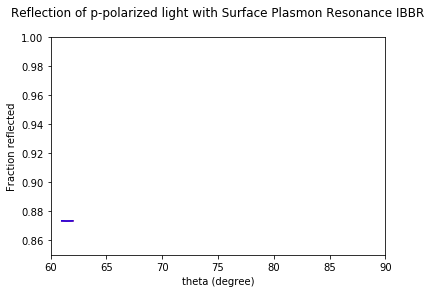

1.45
61.5036691127
1.45
61.5036691127
1.45
61.5036691127


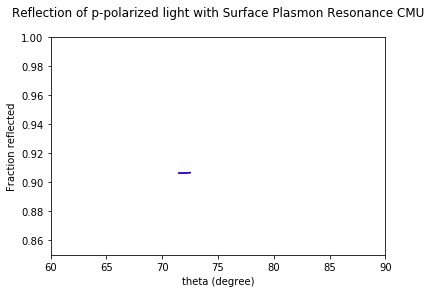

1.45
71.7461641094
1.45
71.7461641094
1.45
71.7461641094


In [28]:
# Simulation Variables

# Refractive index of the bulk and submembrane phase (blank n=1.335)
n_aqueous = 1.335;


# Variables-IBBR
x_ibbr = 5;                   # Selects which element in the array to vary, in this case the bilayer.
x_ibbr_min = 1.45;            # Sets the minimum value of that variable.
x_ibbr_max = 1.45;            # Sets the maximum value of that variable.
x_ibbr_num = 3;               # Determines the number of iterations over which the simulations is ran.
ibbr_csv = csv.writer(open("Adsorbed-IBBR.csv","wb"))


# Variables-CMU
x_cmu = 5;
x_cmu_min = x_ibbr_min;
x_cmu_max = x_ibbr_max;
x_cmu_num = 3;
cmu_csv = csv.writer(open("Adsorbed-CMU.csv","wb"))

# Adjust the range as necessary
theta_list_ibbr = linspace(61*DEGREE, 62*DEGREE, num=1500)
theta_list_cmu = linspace(71.5*DEGREE, 72.5*DEGREE, num=1500)

# Immediately Calculater the Values
plot_IBBR()
sample_IBBR()
plot_CMU()
sample_CMU()
